# 1. 데이터 불러오기

In [3]:
import pandas as pd
from google.colab import files
uploaded=files.upload()

Saving clean_financial_data.csv to clean_financial_data.csv


# 2. 데이터 간단하게 살펴보기

In [11]:
# Load the uploaded file to examine its structure
data = 'clean_financial_data.csv'
data = pd.read_csv(data)

# Display the first few rows, column info, and summary statistics
data_head = data.head()
data_info = data.info()
data_describe = data.describe()

data_head, data_info, data_describe

<ipython-input-11-d4ec72b9b2e9>:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38639 entries, 0 to 38638
Columns: 543 entries, 업체코드 to 2024/감가상각비(구성비)
dtypes: float64(540), object(3)
memory usage: 160.1+ MB


(      업체코드     종목코드    종목명  2020/총자산증가율  2021/총자산증가율  2022/총자산증가율  \
 0  N350605  A000020   동화약품         7.57         2.70         3.27   
 1  N320498  A000040  KR모터스       -36.76         1.45        -0.52   
 2  N320684  A000050     경방        -6.47         0.15        -6.09   
 3  N320730  A000070  삼양홀딩스         6.31        22.28        -0.76   
 4  N310581  A000080  하이트진로        -0.99        10.65        -9.43   
 
    2023/총자산증가율  2024/총자산증가율  2020/유형자산증가율  2021/유형자산증가율  ...  2020/조세공과(구성비)  \
 0        10.23          NaN         19.67         10.41  ...             NaN   
 1        -4.89          NaN         -0.29          5.78  ...             NaN   
 2        -1.40          NaN        -36.42        -23.56  ...             NaN   
 3        17.63          NaN        -45.53        943.89  ...             NaN   
 4        -0.03          NaN         -6.75         -2.60  ...             NaN   
 
    2021/조세공과(구성비)  2022/조세공과(구성비)  2023/조세공과(구성비)  2024/조세공과(구성비)  \
 0             NaN  

# 3. 결측치 처리

In [13]:
import pandas as pd
import seaborn as sns
import numpy as np

data.columns


Index(['업체코드', '종목코드', '종목명', '2020/총자산증가율', '2021/총자산증가율', '2022/총자산증가율',
       '2023/총자산증가율', '2024/총자산증가율', '2020/유형자산증가율', '2021/유형자산증가율',
       ...
       '2020/조세공과(구성비)', '2021/조세공과(구성비)', '2022/조세공과(구성비)', '2023/조세공과(구성비)',
       '2024/조세공과(구성비)', '2020/감가상각비(구성비)', '2021/감가상각비(구성비)',
       '2022/감가상각비(구성비)', '2023/감가상각비(구성비)', '2024/감가상각비(구성비)'],
      dtype='object', length=543)

부실기업은 과거 3년 연속해서 이자보상 배율이 1.0 미만인 기업을 뜻함.

따라서 이자보상 배율에 결측치가 있는지를 확인해야함.

In [16]:
# '영업이익이자보상비율'이 포함된 열들 찾기
columns_with_ratio = [col for col in data.columns if '영업이익이자보상비율' in col]

# 각 열에 대해 결측치 확인
missing_data = data[columns_with_ratio].isnull().sum()

# 결측치가 있는 열 출력
missing_data[missing_data > 0]

,0
2020/영업이익이자보상비율,8768
2021/영업이익이자보상비율,6378
2022/영업이익이자보상비율,4472
2023/영업이익이자보상비율,4810
2024/영업이익이자보상비율,37943


2024년 데이터에 있는 영업이익이자보상비율의 대부분이 결측치이므로 제거해준다

In [17]:
# '2024'가 열 이름에 포함된 열들을 제거
data = data.drop(columns=[col for col in data.columns if '2024' in col], errors='ignore')

In [18]:
# '영업이익이자보상비율'이 포함된 열들 찾기
columns_with_ratio = [col for col in data.columns if '영업이익이자보상비율' in col]

# 결측치가 있는 행 제거
data = data.dropna(subset=columns_with_ratio)

# 결과 확인
print(f"남은 데이터 개수: {data.shape[0]} 행")

남은 데이터 개수: 27604 행


In [22]:
#각 열의 결측값을 중앙값으로 대체
data = data.fillna(data.median(numeric_only=True))

In [23]:
data.dtypes

,0
업체코드,object
종목코드,object
종목명,object
2020/총자산증가율,float64
2021/총자산증가율,float64
...,...
2023/조세공과(구성비),float64
2020/감가상각비(구성비),float64
2021/감가상각비(구성비),float64
2022/감가상각비(구성비),float64


# 4. 이상치 감지

총자산증가율에서 IQR 방식을 이용해본 결과, 연도별로 약 4천 여개의 이상치가 발견됨.

In [21]:
# Step 1: Check for missing values in each column
missing_values = data.isnull().sum()
missing_values_percentage = (missing_values / len(data)) * 100

# Step 2: Check data types for potential conversion needs
data_types = data.dtypes

# Step 3: Basic statistics of numerical columns
numerical_summary = data.describe()

# Step 4: Detect potential outliers using IQR for selected columns (e.g., 총자산증가율)
# Selecting a subset of columns for outlier detection (considering a sample due to large number of columns)
sample_columns = ['2020/총자산증가율', '2021/총자산증가율', '2022/총자산증가율', '2023/총자산증가율']
Q1 = data[sample_columns].quantile(0.25)
Q3 = data[sample_columns].quantile(0.75)
IQR = Q3 - Q1
outliers = ((data[sample_columns] < (Q1 - 1.5 * IQR)) | (data[sample_columns] > (Q3 + 1.5 * IQR))).sum()

# Step 5: Check for duplicate rows
duplicate_rows = data.duplicated().sum()

missing_values_percentage, data_types, numerical_summary, outliers, duplicate_rows


(업체코드                0.000000
 종목코드               88.400232
 종목명                 0.003623
 2020/총자산증가율         0.000000
 2021/총자산증가율         0.000000
                      ...    
 2023/조세공과(구성비)      0.000000
 2020/감가상각비(구성비)     0.000000
 2021/감가상각비(구성비)     0.000000
 2022/감가상각비(구성비)     0.000000
 2023/감가상각비(구성비)     0.000000
 Length: 435, dtype: float64,
 업체코드                object
 종목코드                object
 종목명                 object
 2020/총자산증가율        float64
 2021/총자산증가율        float64
                     ...   
 2023/조세공과(구성비)     float64
 2020/감가상각비(구성비)    float64
 2021/감가상각비(구성비)    float64
 2022/감가상각비(구성비)    float64
 2023/감가상각비(구성비)    float64
 Length: 435, dtype: object,
         2020/총자산증가율   2021/총자산증가율   2022/총자산증가율   2023/총자산증가율  2020/유형자산증가율  \
 count  2.760400e+04  2.760400e+04  27604.000000  27604.000000  2.760400e+04   
 mean   5.062082e+04  3.519060e+02     20.793923     10.154860  9.685926e+04   
 std    6.615210e+06  4.764773e+04    370.935699     66.347096 

총자산증가율은 기업의 규모(자기자본+부채)가 얼마나 증가했는지를 보여주는 성장지표.


총자산이 증가하지 않거나, 부채의 증가로 인하여 자산증가율이 높아지는 것은 부실로 연결 가능.

(우리끼리는 3년 연속 이자보상배율이 1 미만인 걸 부실 기업으로 했지만
총자산증가율으로도 혹시나 부실 기업이라고 얘기하는데 더 보줄 수 있을까봐 해봤는데 데이터 값이 너무 왔다갔다 해서 포기...)

In [25]:
# Extract columns containing "총자산증가율" for each year
total_asset_growth_columns = [col for col in data.columns if '총자산증가율' in col]

# Create a new DataFrame with only the 총자산증가율 columns
total_asset_growth_data = data[total_asset_growth_columns]

# Display the first few rows of the new DataFrame to inspect
print("Total Asset Growth Data by Year:\n", total_asset_growth_data.head())


Total Asset Growth Data by Year:
    2020/총자산증가율  2021/총자산증가율  2022/총자산증가율  2023/총자산증가율
0         7.57         2.70         3.27        10.23
1       -36.76         1.45        -0.52        -4.89
2        -6.47         0.15        -6.09        -1.40
3         6.31        22.28        -0.76        17.63
4        -0.99        10.65        -9.43        -0.03


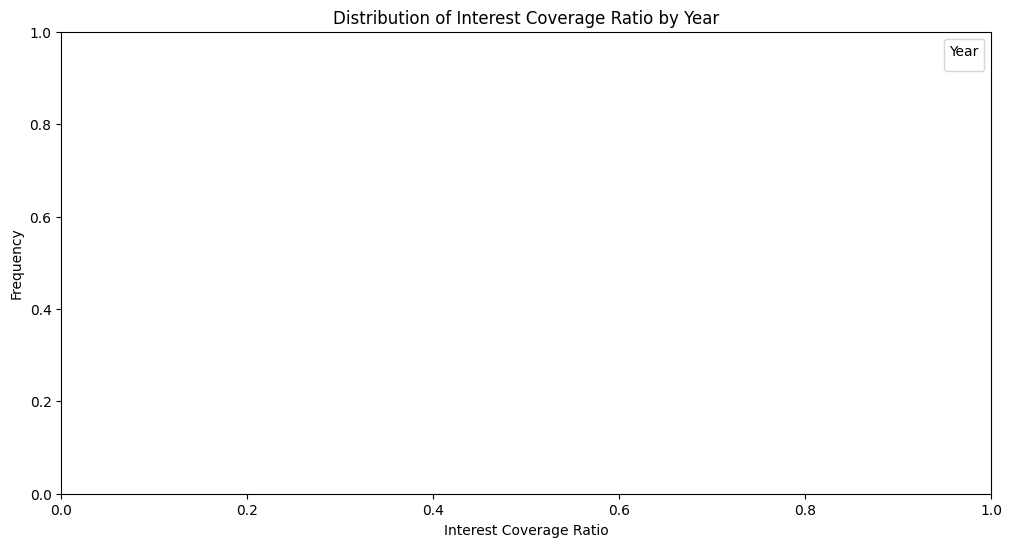

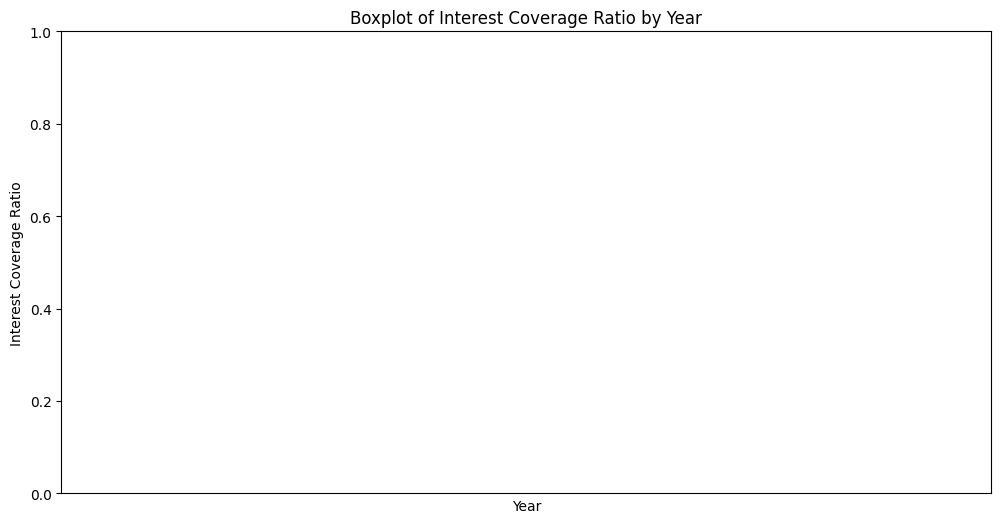

Sample of data with new insolvent company columns:
 Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# '영업이익보상비율' 관련 열 추출
interest_coverage_columns = [col for col in data.columns if '영업이익보상비율' in col]
interest_coverage_data = data[interest_coverage_columns]

# 2. 분포 확인 - 히스토그램
plt.figure(figsize=(12, 6))
for col in interest_coverage_columns:
    sns.histplot(interest_coverage_data[col], kde=True, bins=30, label=col)
plt.title("Distribution of Interest Coverage Ratio by Year")
plt.xlabel("Interest Coverage Ratio")
plt.ylabel("Frequency")
plt.legend(title="Year")
plt.show()

# 3. 분포 확인 - 박스 플롯
plt.figure(figsize=(12, 6))
sns.boxplot(data=interest_coverage_data)
plt.title("Boxplot of Interest Coverage Ratio by Year")
plt.xlabel("Year")
plt.ylabel("Interest Coverage Ratio")
plt.xticks(ticks=range(len(interest_coverage_columns)), labels=interest_coverage_columns, rotation=45)
plt.show()

# 4. 부실 기업 비율 확인
for col in interest_coverage_columns:
    insolvent_ratio = (interest_coverage_data[col] < 1).mean() * 100
    print(f"Percentage of insolvent companies in {col}: {insolvent_ratio:.2f}%")

# ====== 전처리 코드 ======

# 결측치 처리 - 결측값을 중앙값으로 대체
for col in interest_coverage_columns:
    data[col].fillna(data[col].median(), inplace=True)

# 이상치 처리 - IQR 방식으로 이상치를 상한선과 하한선으로 조정
for col in interest_coverage_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# 부실기업 컬럼 생성 - 영업이익보상비율이 1 미만인 경우 1, 그렇지 않으면 0으로 설정
for col in interest_coverage_columns:
    data[f'부실기업_{col}'] = data[col].apply(lambda x: 1 if x < 1 else 0)

# 부실기업 컬럼 예시 확인
print("Sample of data with new insolvent company columns:\n", data[[f'부실기업_{col}' for col in interest_coverage_columns]].head())
